## FINM 35910 - Applied Algorithmic Trading - Szajkowski, Jared
### Homework 3: Optimization And Parameter Tuning

### Python Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from IPython.display import display
import warnings
import itertools
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Python Functions

In [2]:
# Import functions from .py files

# Function to combine the price data for the crypto assets
import combine_data_func

# Function to execute the strategy
import strategy_func

# Function to calcuate the summary stats
import summary_stats_func

# Functions to display plots
from plot_func import plot_cumulative_return
from plot_func import plot_values
from plot_func import plot_drawdown
from plot_func import plot_buy_hold
from plot_func import plot_price
from plot_func import plot_cum_trans_costs

### Introduction

For homework 3, we will be using the same strategy that we developed in homework 2. Recall some of the high level details of the strategy that was outlined in homework 2:

- Define the investment hypothesis and objectives, aiming for excess returns above the benchmark.

The investment objectives are two-fold. First, the fund seeks to provide the maximum total return by diversifying across crypto assets that are trending up in value. The fund is long only and seeks to take advantage of the volatility that has been present (and is expected to continue) in the crypto markets. Second, the fund seeks to minimize drawdowns by using a variety of trend following signals to reduce exposure to crypto assets that are trending down in value. As assets increase and decrease in value, the strategy rotates positions in and out of the various assets. Due to the volatile nature of crypto, there is value in reducing exposure as assets are declining in value to avoid a total loss should the value of an asset go to zero.

- Consider (if applicable) and detail various parameters like investment universe, return definition, rebalancing frequency, transaction costs, start and end dates of testing period.

The investment universe consists of crypto assets, to include initially Bitcoin and Ethereum. Other assets will be evaluated as historical data is available and evaluted to be included in the strategy. Rebalancing is set to take place every 10 days, but is subject to change based on the strategy performance and other considerations such as trading costs. Starting and ending dates for the backtesting period is from mid 2016 to the present. Return definition is the classic definition. The strategy tracks returns on a daily basis, which is is 365 days per year because crypto assets trade everyday, 24 hours per day.

- State the benchmark, if applicable.

The benchmark to be compared to is a buy-and-hold allocation to each of the crypto assets that is being used in the strategy. The comparison to the benchmark is shown below in the plots. Given that the trend following strategy is essentially attempting to reduce the volatility inherent to crypto assets while matching or beating the returns, it makes the most sense to use a benchmark such as the a buy-and-hold allocation.

- Define clear and testable hypotheses for the strategy, including specific entry and exit criteria.

The entry and exit criteria are determined based on a a "trend strength" indicator that is determined by evaluating whether an asset is trending up or down based on whether or not the current price is higher or lower than the 10, 20, ... , 90 day exponential moving averages. If the current price is higher than a specific EMA traunch, then the indicator is considered a +1. If it is lower, then the indicator is considered a 0. The indicator is determined through this method and the level of the indicator determines the allocation to the asset. As previously mentioned the portfolio is rebalanced daily, which allows for reaction to recent market events and movements, but also incurs higher transaction costs. The strategy does not short sell due to the limitations of Coinbase, but it would be worthwhile to investigate in the future if put options could be used as a proxy for short selling.

- Discuss market impact and liquidity concerns/constraints when setting objectives.

Based on the volumes available from the chosen exchange (Coinbase), liquidity and market depth is not an issue for a reasonable portfolio size ( < $50m).

- Construct the portfolio using historical or simulated data. If simulated, please explain the choice and detail the steps.

The portfolio is constructed using historical data available from Coinbase. The data is pulled from coinbase with a python script and then stored locally for easy access, use, and updating later on. The data to be used is the 24 hour candle data, but the strategy uses the 24 hour close/adjusted close prices.

- Discuss, if applicable, rebalancing frequencies such as monthly, quarterly, or custom intervals.

Given that crypto exchanges trade 24 hrs / day, the idea is that the strategy is run daily directly after the close of the 24 hour period, and any rebalancing is done immediately at that time. This means that any rebalancing will take place within seconds, literally, of what the close price is for the previous 24 hours. This gives assurances that using the close/adjusted close price for the strategy backtest is a valid method and that the strategy will not incure signficant slippage or loss due to crossing bid-ask spreads.

### Question 1
1. Define Optimization Goals:

Clearly outline the objectives of the optimization process, whether it's maximizing profits, minimizing risk, or achieving a specific risk-adjusted return metric.

### Answer

Our objectives with optimizing the strategy include the follow:

1. Maximize the annualized return (CAGR)
2. Minimize the drawdown

Relating the annualized return and maximum drawdown has historically been measured as the Calmar or MAR ratio, through the following:

Calmar or MAR = Annualized Return / Maximum Drawdown 

The Calmar ratio typically includes only the past 36 months of investment history, whereas the MAR ratio includes the history since inception of the fund. Therefore, we will consider the MAR for our analysis.

### Question 2
2. Identify Parameters:

Identify the key parameters in your trading algorithm that can be adjusted, such as moving average periods, entry and exit thresholds, stop-loss levels, and position sizing parameters.

### Answer

The key parameters for our algorithm that can be optimized include the following:

1. Number and duration of EMA invervals: This includes the number of intervals and the durations for which we are calculating the EMAs, such as 5 day or 10 day or 20 day, etc. different lookback periods.
2. Rebalancing frequency: This is the frequency with which the portfolio is actually rebalanced, such as every day, every other day, every 5th day, every 7th day, etc.
3. Number of traded assets: This is the number of different assets included in the strategy, and could include just BTC, or BTC and ETH, etc.

### Question 3
3. Set Parameter Ranges:

Define the ranges or constraints for each parameter. Determine the minimum, maximum, and step size for numerical parameters, ensuring a reasonable and practical range.

### Answer

Based on the answer to question 2 above, the ranges and constraints for each of the key parameters for our algorithm that can be optimized include the following:

1. Number and duration of EMA invervals: This includes the number of intervals and the durations for which we are calculating the EMAs, such as 5 day or 10 day or 20 day, etc. different lookback periods.

* Minimum value: 7 days
* Maximum value: 119 days (roughly, this will not be exact due to the varying interval duration)
* Step size: 7 days
 
2. Rebalancing frequency: This is the frequency with which the portfolio is actually rebalanced, such as every day, every other day, every 5th day, every 7th day, etc.

* Minimum value: 7 days
* Maximum value: 7 days
* Step size: 7 day

3. Number of traded assets: This is the number of different assets included in the strategy, and could include just BTC, or BTC and ETH, etc.

* Minimum value: 1 asset
* Maximum value: 7 assets
* Step size: 1 asset

### Question 4
4. Choose an Optimization Method:

Select an optimization method such as grid search, random search, regime switch, genetic algorithms, simulated annealing, Bayesian optimization, or even a custom method. (Consider the complexity of your strategy and the computational resources available when choosing the appropriate optimization method.)

### Answer

We will iterate through a likely set of parameters to see what values provide the best optimization. Based on the above, the total number of combinations that we can have is as follows:

In [3]:
# Total Combinations

# Start of range for sma_list
# start = [i for i in range(1, 11)]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
start = [7]

# End of range for sma_list
# stop = [i for i in range(90, 361, 10)]  # [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]
stop = [i for i in range(56, 120, 28)]  # [60, 90, 120, 150, 180]

# Step of range for sma_list
# step = [i for i in range(1, 11)]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
step = [7]

# List of funds to choose from
funds_available = ["ADA-USD", "AVAX-USD", "BTC-USD", "DOGE-USD", "ETH-USD", "SOL-USD", "XRP-USD"]

# Generate all possible combinations for the funds to be used
fund_combinations = []
for r in range(1, len(funds_available) + 1):
    fund_combinations.extend(itertools.combinations(funds_available, r))

# List of rebalance intervals
# rebal_intervals = [i for i in range(1, 11)]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rebal_intervals = [7]

count = 0

for r in rebal_intervals:
    for combo in fund_combinations:
        for i in start:
            for j in stop:
                for k in step:
                    if i < j and k > 0:  # Ensure valid range arguments
                        count = count + 1

print(f"This is the number of possible combinations: {count}")

This is the number of possible combinations: 381


Before we run the optimiztion, we will confirm that the data sets match:

In [4]:
# List of Excel files to process
funds_available = ["ADA-USD", "AVAX-USD", "BTC-USD", "DOGE-USD", "ETH-USD", "SOL-USD", "XRP-USD"]

# Initialize a list to store results
results = []

# Iterate through the list of files
for file in funds_available:
    try:
        # Load the Excel file
        df = pd.read_excel("Data/" + file + ".xlsx")

        # Ensure the 'Date' column is in datetime format
        # Adjust the column name if necessary
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Drop rows with invalid dates
        df = df.dropna(subset=['Date'])

        # Get the first and last dates
        first_date = df['Date'].min()
        last_date = df['Date'].max()

        # Append results
        results.append({'File': os.path.basename(file), 'First Date': first_date, 'Last Date': last_date})
    except Exception as e:
        # Handle errors gracefully and log the issue
        results.append({'File': os.path.basename(file), 'First Date': None, 'Last Date': None, 'Error': str(e)})

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,File,First Date,Last Date
0,ADA-USD,2021-09-30,2024-09-30
1,AVAX-USD,2021-09-30,2024-09-30
2,BTC-USD,2021-09-30,2024-09-30
3,DOGE-USD,2021-09-30,2024-09-30
4,ETH-USD,2021-09-30,2024-09-30
5,SOL-USD,2021-09-30,2024-09-30
6,XRP-USD,2021-09-30,2024-09-30


### Question 5
5. Perform Optimization:

Apply the chosen optimization method to systematically test parameters or a different combination of parameters within the defined ranges.Evaluate the strategy's performance based on predefined metrics, considering both in-sample and out-of-sample data, and execute again if necessary.

### Answer

As follows is the iterations for the selected parameters.

In [ ]:
# Executing The Optimization

# Start of range for sma_list
# start = [i for i in range(1, 11)]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
start = [7]

# End of range for sma_list
# stop = [i for i in range(90, 361, 10)]  # [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]
stop = [i for i in range(56, 120, 28)]  # [60, 90, 120, 150, 180]

# Step of range for sma_list
# step = [i for i in range(1, 11)]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
step = [7]

# List of funds to choose from
funds_available = ["ADA-USD", "AVAX-USD", "BTC-USD", "DOGE-USD", "ETH-USD", "SOL-USD", "XRP-USD"]

# Generate all possible combinations for the funds to be used
fund_combinations = []
for r in range(1, len(funds_available) + 1):
    fund_combinations.extend(itertools.combinations(funds_available, r))

# List of rebalance intervals
# rebal_intervals = [i for i in range(1, 11)]  # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rebal_intervals = [7]

count = 0

combined_stats = pd.DataFrame(columns = ['EMA List', 'Fund List', 'Rebalance Frequency', 'Annualized Mean', 'Annualized Volatility', 
                                         'Annualized Sharpe Ratio', 'CAGR', 'Daily Max Return', 'Daily Max Return (Date)', 'Daily Min Return', 
                                         'Daily Min Return (Date)', 'Max Drawdown', 'Peak', 'Bottom', 'Recovery Date'])

for r in rebal_intervals:
    for combo in fund_combinations:
        for i in start:
            for j in stop:
                for k in step:
                    if i < j and k > 0:  # Ensure valid range arguments

                        # List of EMA / SMA intervals
                        sma_list = [str(a) for a in range(i, j, k)]
                        # print(sma_list)

                        # Number of EMA / SMA intervals
                        num_sma = len(sma_list)

                        # List of funds to be used
                        fund_list = list(combo)

                        # Number of funds
                        num_funds = len(fund_list)

                        # Starting cash contribution
                        starting_cash = 10000

                        # Monthly cash contribution
                        cash_contrib = 0

                        # Combine price data for each asset
                        combine_data_func.combine_data(fund_list, "Daily")

                        # Rebalance interval
                        rebal_interval = r

                        # Transaction fee
                        transaction_fee = 0.005

                        # Execute strategies and append results to dataframe
                        strat = strategy_func.strategy(sma_list, num_sma, num_funds, fund_list, starting_cash, cash_contrib, rebal_interval, transaction_fee).set_index('Date')

                        # Calculate summary stats
                        sum_stats = summary_stats_func.summary_stats(fund_list, strat[['Return']], "Daily")

                        # Update count
                        count = count + 1

                        # Concat to df
                        combined_stats.loc["Combination " + str(count), 'EMA List'] = sma_list
                        combined_stats.loc["Combination " + str(count), 'Fund List'] = fund_list
                        combined_stats.loc["Combination " + str(count), 'Rebalance Frequency'] = rebal_interval
                        combined_stats.loc["Combination " + str(count), 'Annualized Mean'] = sum_stats.iloc[0]['Annualized Mean']
                        combined_stats.loc["Combination " + str(count), 'Annualized Volatility'] = sum_stats.iloc[0]['Annualized Volatility']
                        combined_stats.loc["Combination " + str(count), 'Annualized Sharpe Ratio'] = sum_stats.iloc[0]['Annualized Sharpe Ratio']
                        combined_stats.loc["Combination " + str(count), 'CAGR'] = sum_stats.iloc[0]['CAGR']
                        combined_stats.loc["Combination " + str(count), 'Daily Max Return'] = sum_stats.iloc[0]['Daily Max Return']
                        combined_stats.loc["Combination " + str(count), 'Daily Max Return (Date)'] = sum_stats.iloc[0]['Daily Max Return (Date)']
                        combined_stats.loc["Combination " + str(count), 'Daily Min Return'] = sum_stats.iloc[0]['Daily Min Return']
                        combined_stats.loc["Combination " + str(count), 'Daily Min Return (Date)'] = sum_stats.iloc[0]['Daily Min Return (Date)']
                        combined_stats.loc["Combination " + str(count), 'Max Drawdown'] = sum_stats.iloc[0]['Max Drawdown']
                        combined_stats.loc["Combination " + str(count), 'Peak'] = sum_stats.iloc[0]['Peak']
                        combined_stats.loc["Combination " + str(count), 'Bottom'] = sum_stats.iloc[0]['Bottom']
                        combined_stats.loc["Combination " + str(count), 'Recovery Date'] = sum_stats.iloc[0]['Recovery Date']

                        # Display summary stats
                        # display(combined_stats)

                        # Export strategy to excel
                        file = "Strategy_Stats.xlsx"
                        location = file
                        combined_stats.to_excel(location, sheet_name='data')
                        print(count)

The file 'Data/ADA-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for ADA-USD.
Summary stats complete for ADA-USD.
1
The file 'Data/ADA-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for ADA-USD.
Summary stats complete for ADA-USD.
2
The file 'Data/ADA-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for ADA-USD.
Summary stats complete for ADA-USD.
3
The file 'Data/AVAX-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for AVAX-USD.
Summary stats complete for AVAX-USD.
4
The file 'Data/AVAX-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for AVAX-USD.
Summary stats complete for AVAX-USD.
5
The file 'Data/AVAX-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for AVAX-USD.
Summary stats complete for AVAX-USD.
6
The file 'Data/BTC-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy c

In [12]:
combined_stats['MAR'] = combined_stats['CAGR'] / combined_stats['Max Drawdown']
combined_stats_sorted = combined_stats.sort_values(by = ['MAR'], ascending=True)
combined_stats_sorted.head(1)

,EMA List,Fund List,Rebalance Frequency,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date,MAR
Combination 49,"[7, 14, 21, 28, 35, 42, 49]","[AVAX-USD, SOL-USD]",7,0.6375,0.5529,1.1531,0.6269,0.1978,2023-01-14 00:00:00,-0.1255,2024-03-19 00:00:00,-0.4430,2021-11-22 00:00:00,2022-11-09 00:00:00,2023-11-09 00:00:00,-1.4151


### Question 6
6. Provide Results:

Provide the optimization results to identify parameter sets that yield the best performance metrics, such as highest returns, lowest drawdowns, or optimal risk-adjusted ratios.

### Answer

Based on the above, we can see that the combination with the highest MAR is combination 49. Interestingly, this combination only uses AVAX-USD and SOL-USD to achieve the compound annual growth rate of 62%, the maximum drawdown of 44%, and the annualized Sharpe ratio of 1.15. For this combination the MAR is -1.41, which is the value that we are attempting to maximize (really minimize if the drawdown is being considered as a negative number). The following are the relevant plots for combination 49:


In [16]:
# Executing The Strategy 

# List of EMA / SMA intervals
sma_list = ['7', '14', '21', '28', '35', '42', '49']

# Number of EMA / SMA intervals
num_sma = len(sma_list)

# List of funds to be used
# fund_list = ['BTC-USD', 'ETH-USD', 'BCH-USD', 'LINK-USD', 'LTC-USD']
fund_list = ['AVAX-USD', 'SOL-USD']

# Number of funds
num_funds = len(fund_list)

# Starting cash contribution
starting_cash = 10000

# Monthly cash contribution
cash_contrib = 0

# Combine price data for each asset
combine_data_func.combine_data(fund_list, 'Daily')

# Rebalance interval
rebal_interval = 7

# Transaction fee
transaction_fee = 0.005

# Execute strategy
strat = strategy_func.strategy(sma_list, num_sma, num_funds, fund_list, starting_cash, cash_contrib, rebal_interval, transaction_fee).set_index('Date')

# Calculate summary stats
sum_stats = summary_stats_func.summary_stats(fund_list, strat[['Return']], 'Daily')

# Display summary stats
display(sum_stats)

The file 'Data/AVAX-USD_SOL-USD_Combined_Data.xlsx' already exists. Combine data aborted.
Strategy complete for AVAX-USD_SOL-USD.
Summary stats complete for AVAX-USD_SOL-USD.


,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Bottom,Recovery Date
Return,0.6375,0.5529,1.1531,0.6269,0.1978,2023-01-14,-0.1255,2024-03-19,-0.4430,2021-11-22,2022-11-09,2023-11-09


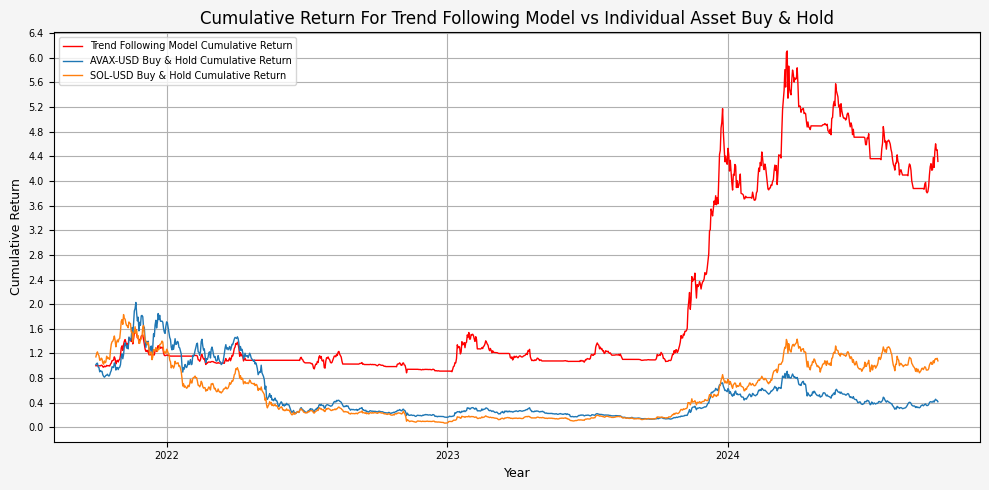

In [17]:
plot_cumulative_return(strat, fund_list, export_plot = "No")

Similarly, as follows is a plot to compare the portfolio values with an assumed initial $10,000 allocation.

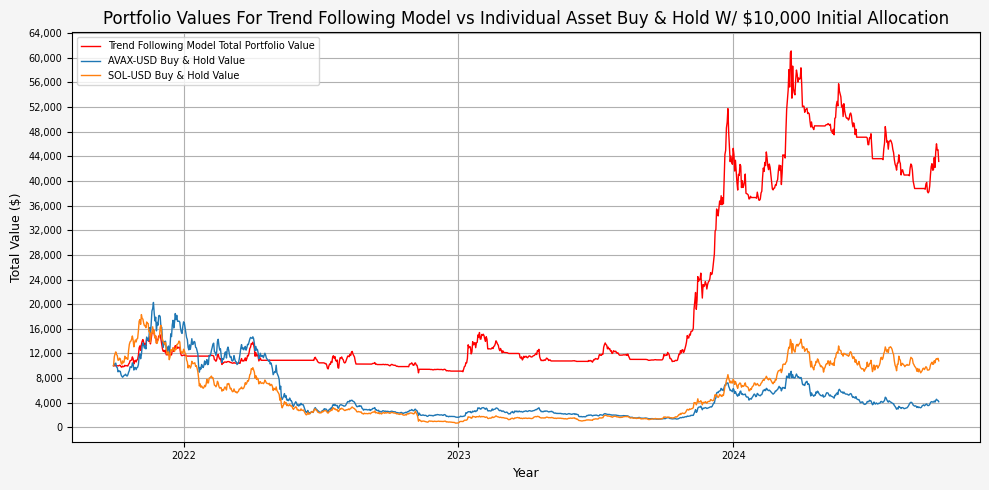

In [18]:
plot_buy_hold(strat, fund_list, export_plot = "No")

Next, we have the plot that shows the drawdowns for the strategy as well as the two benchmarks.

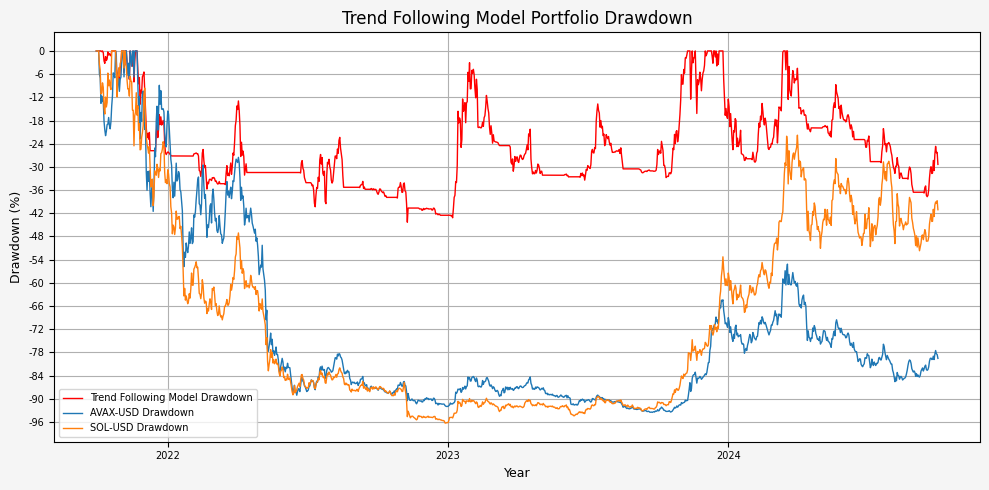

In [19]:
plot_drawdown(strat, fund_list, export_plot = "No")

Next, we have the plot showing the total portfolio value alongside the cash value and "equity" value. Of course here when we use the term "equity" it is synonymous with the crypto asssets.

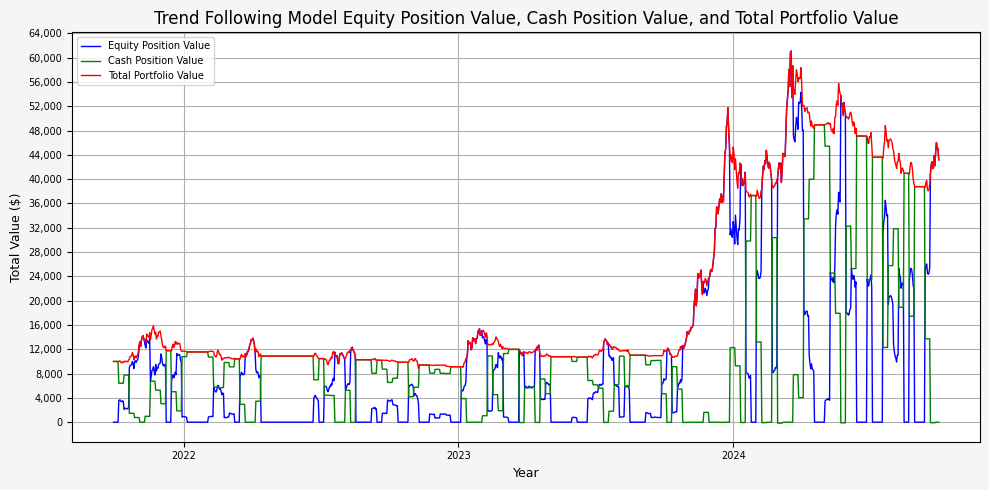

In [20]:
plot_values(strat, export_plot = "No")

And finally, we have the plot showing the cumulative transaction / trading costs for the life of the strategy. It can be seen that the transaction costs become substantial in value, and additional investigation would be needed to determine if the strategy is overtrading and needs to be modified to reduce the trading costs while still maintaining the alpha and relatively uncorrelated returns.

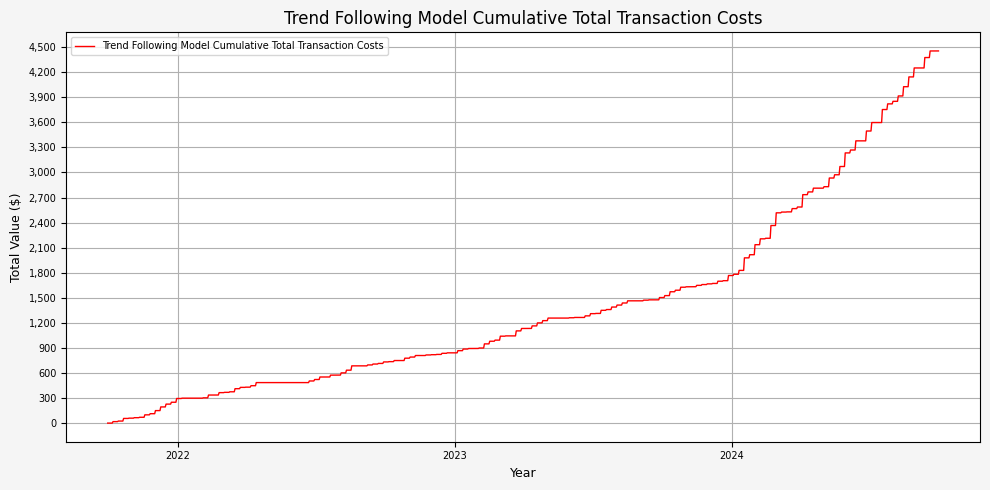

In [21]:
plot_cum_trans_costs(strat, export_plot = "No")